# Import libraries

In [1]:
from gumps.graph.regressor import RegressorPlotParameters, RegressorPlot
from gumps.solvers.regressors.pytorch_regressor import TorchMultiLayerPerceptronRegressor, TorchMultiLayerPerceptronRegressionParameters, OptunaParameters
import pandas as pd
import numpy as np
from gumps.studies.batch_study import AbstractBatchStudy
from typing import Callable

from gumps.solvers.sampler import SamplerSolverParameters
from gumps.apps.parametric_sweep import ParametricSweepApp

%matplotlib inline

ImportError: /home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/torch/lib/libtorch_cpu.so: undefined symbol: iJIT_NotifyEvent

First we need to create some tests data. We need to create input and output data that requires a combination of linear scaling and logarithmic scaling. It needs to be implemented using the Batch Study interface so we can sample it effectively.

In [2]:
# a will require log-scaling
# b will require linear-scaling
# c will range from -1 to 1
# d will require logs-scaling

# w will require linear scaling
# x will require log-scaling
# y will range from 0 to 1
# z will require log-scaling

class SyntheticBatchStudy(AbstractBatchStudy):
    "batch version of sphere study (designed to approximate surrogate model)"

    def __init__(self, *, model_variables:dict):
        self.model_variables = model_variables

    def start(self):
        "initialize this study"

    def stop(self):
        "handle shutdown tasks"

    def run(self, input_data:pd.DataFrame, processing_function:Callable|None=None) -> pd.DataFrame:
        "run the batch simulation"
        output_data = pd.DataFrame()
        output_data["w"] = np.log(input_data["a"]) * input_data['b']
        output_data["x"] = np.exp(input_data['b'])
        output_data["y"] = input_data['c']**2
        output_data["z"] = input_data['d'] * input_data['b']

        self.save_results(input_data, output_data)

        if processing_function is None:
            return output_data
        else:
            return processing_function(output_data)

# Create a parametric sweep object

In [3]:
def get_all(frame:pd.DataFrame) -> pd.DataFrame:
    "processing function to get the total from the dataframe"
    return frame

In [4]:
batch = SyntheticBatchStudy(model_variables={})

parameters = SamplerSolverParameters(
    number_of_samples = 1000,
    lower_bound = {'a':1e0, 'b':1, 'c':-1, 'd':1e-7},
    upper_bound = {'a':1e7, 'b':100, 'c':1, 'd':1e-2},
    sampler = "sobol"
    )

app = ParametricSweepApp(parameters=parameters,
        processing_function=get_all,
        directory=None,
        batch=batch)
app.run()

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Build and train a basic pytorch regressor

In [5]:
mlp_reg_data = TorchMultiLayerPerceptronRegressionParameters(input_data=app.factors, 
                                        output_data=app.responses,
                                        learning_rate="adaptive",
                                        hidden_layer_sizes=[50,],
                                        learning_rate_patience=10,
                                        learning_rate_factor=0.5,
                                        learning_rate_init=0.01,
                                        early_stopping_patience=20,
                                        train_test_split="sequential",
                                        validation_fraction=0.3,
                                        max_iter=250,
                                        batch_size=128)

mlp_regressor = TorchMultiLayerPerceptronRegressor(mlp_reg_data)
mlp_regressor.fit()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 454   
---------------------------------------
454       Trainable params
0         Non-trainable params
454       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 249: 100%|██████████| 6/6 [00:00<00:00, 126.16it/s, val_loss=8.02e-5, train_loss=7.93e-5]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 6/6 [00:00<00:00, 116.18it/s, val_loss=8.02e-5, train_loss=7.93e-5]


In [6]:
print(f"Error: {mlp_regressor.error_metrics()['nrmse']}")
print(mlp_regressor.parameters.get_mlp_parameters())

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 296.31it/s]
Error: 0.017370809701769418
MLPParameters(input_dim=4, output_dim=4, hidden_layer_sizes=[50], activation=<class 'torch.nn.modules.activation.SiLU'>, learning_rate='adaptive', learning_rate_init=0.01, learning_rate_patience=10, learning_rate_factor=0.5)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 333.14it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.01it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.64it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 178.85it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.50it/s]


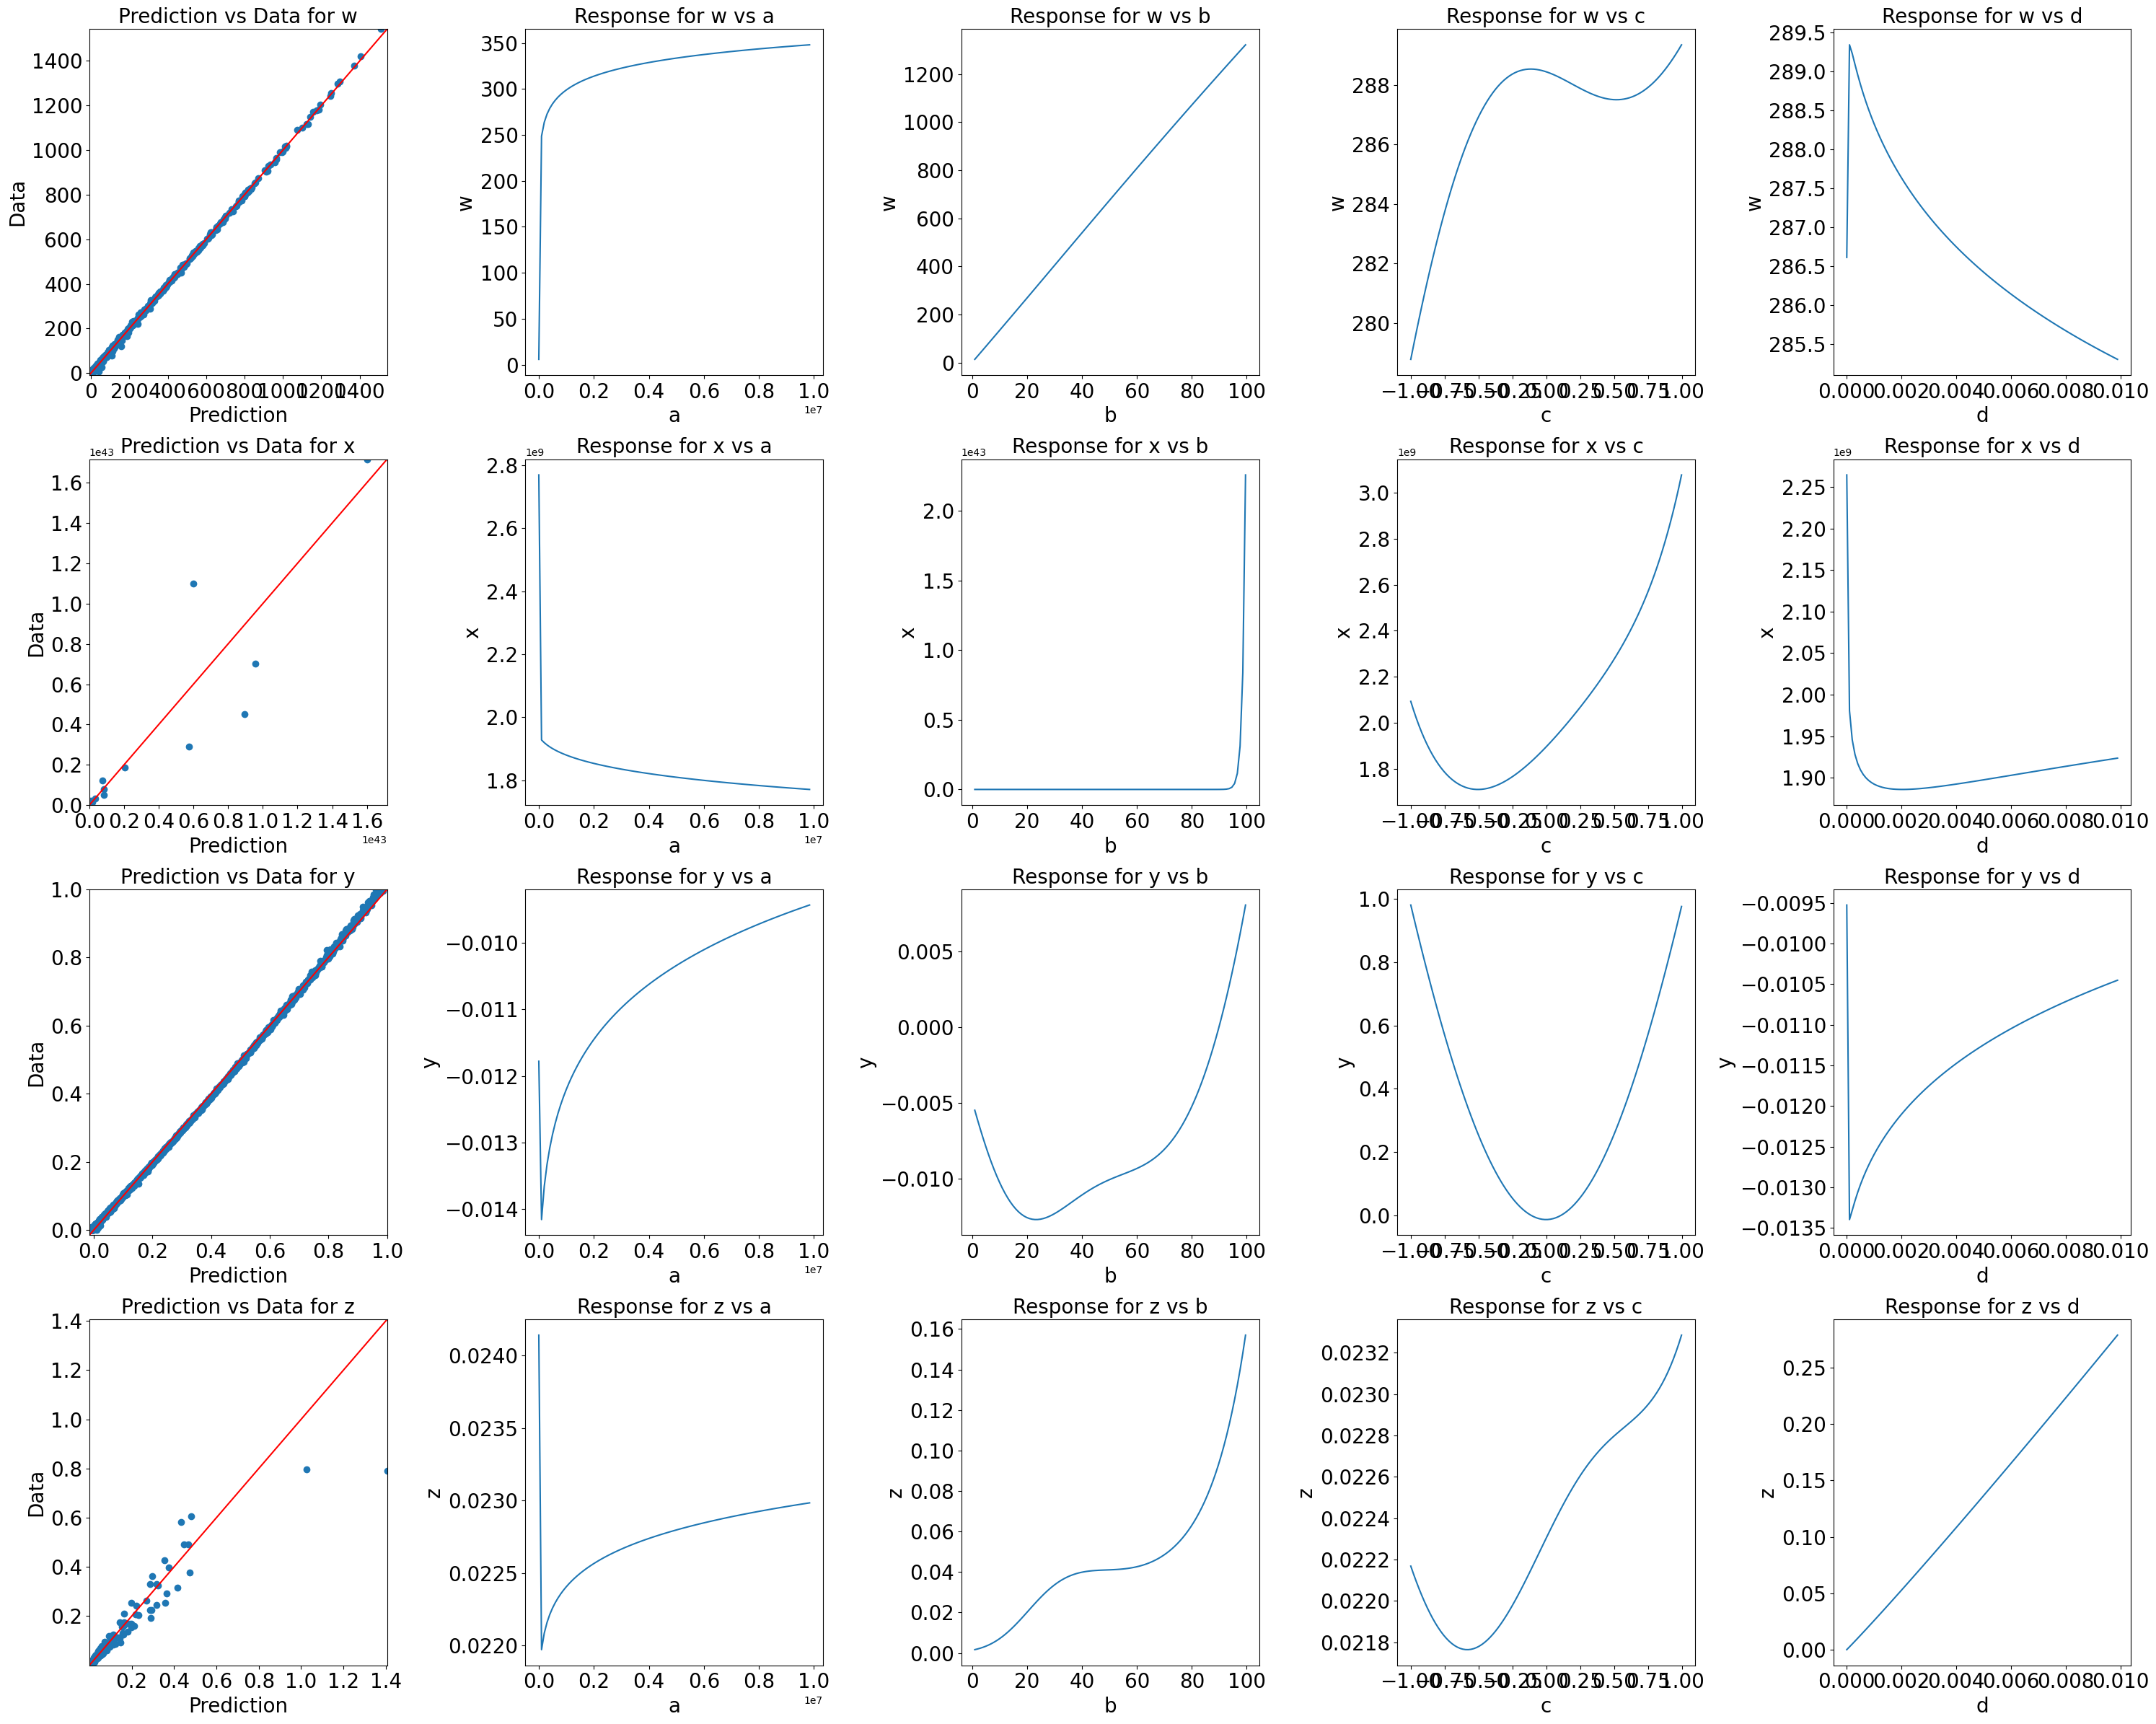

In [7]:
params = RegressorPlotParameters(mlp_regressor, app.factors.mean(), app.factors.min(), app.factors.max())
reg_plot = RegressorPlot(params)
reg_plot.plot()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 322.37it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.11it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.14it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.94it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 178.79it/s]


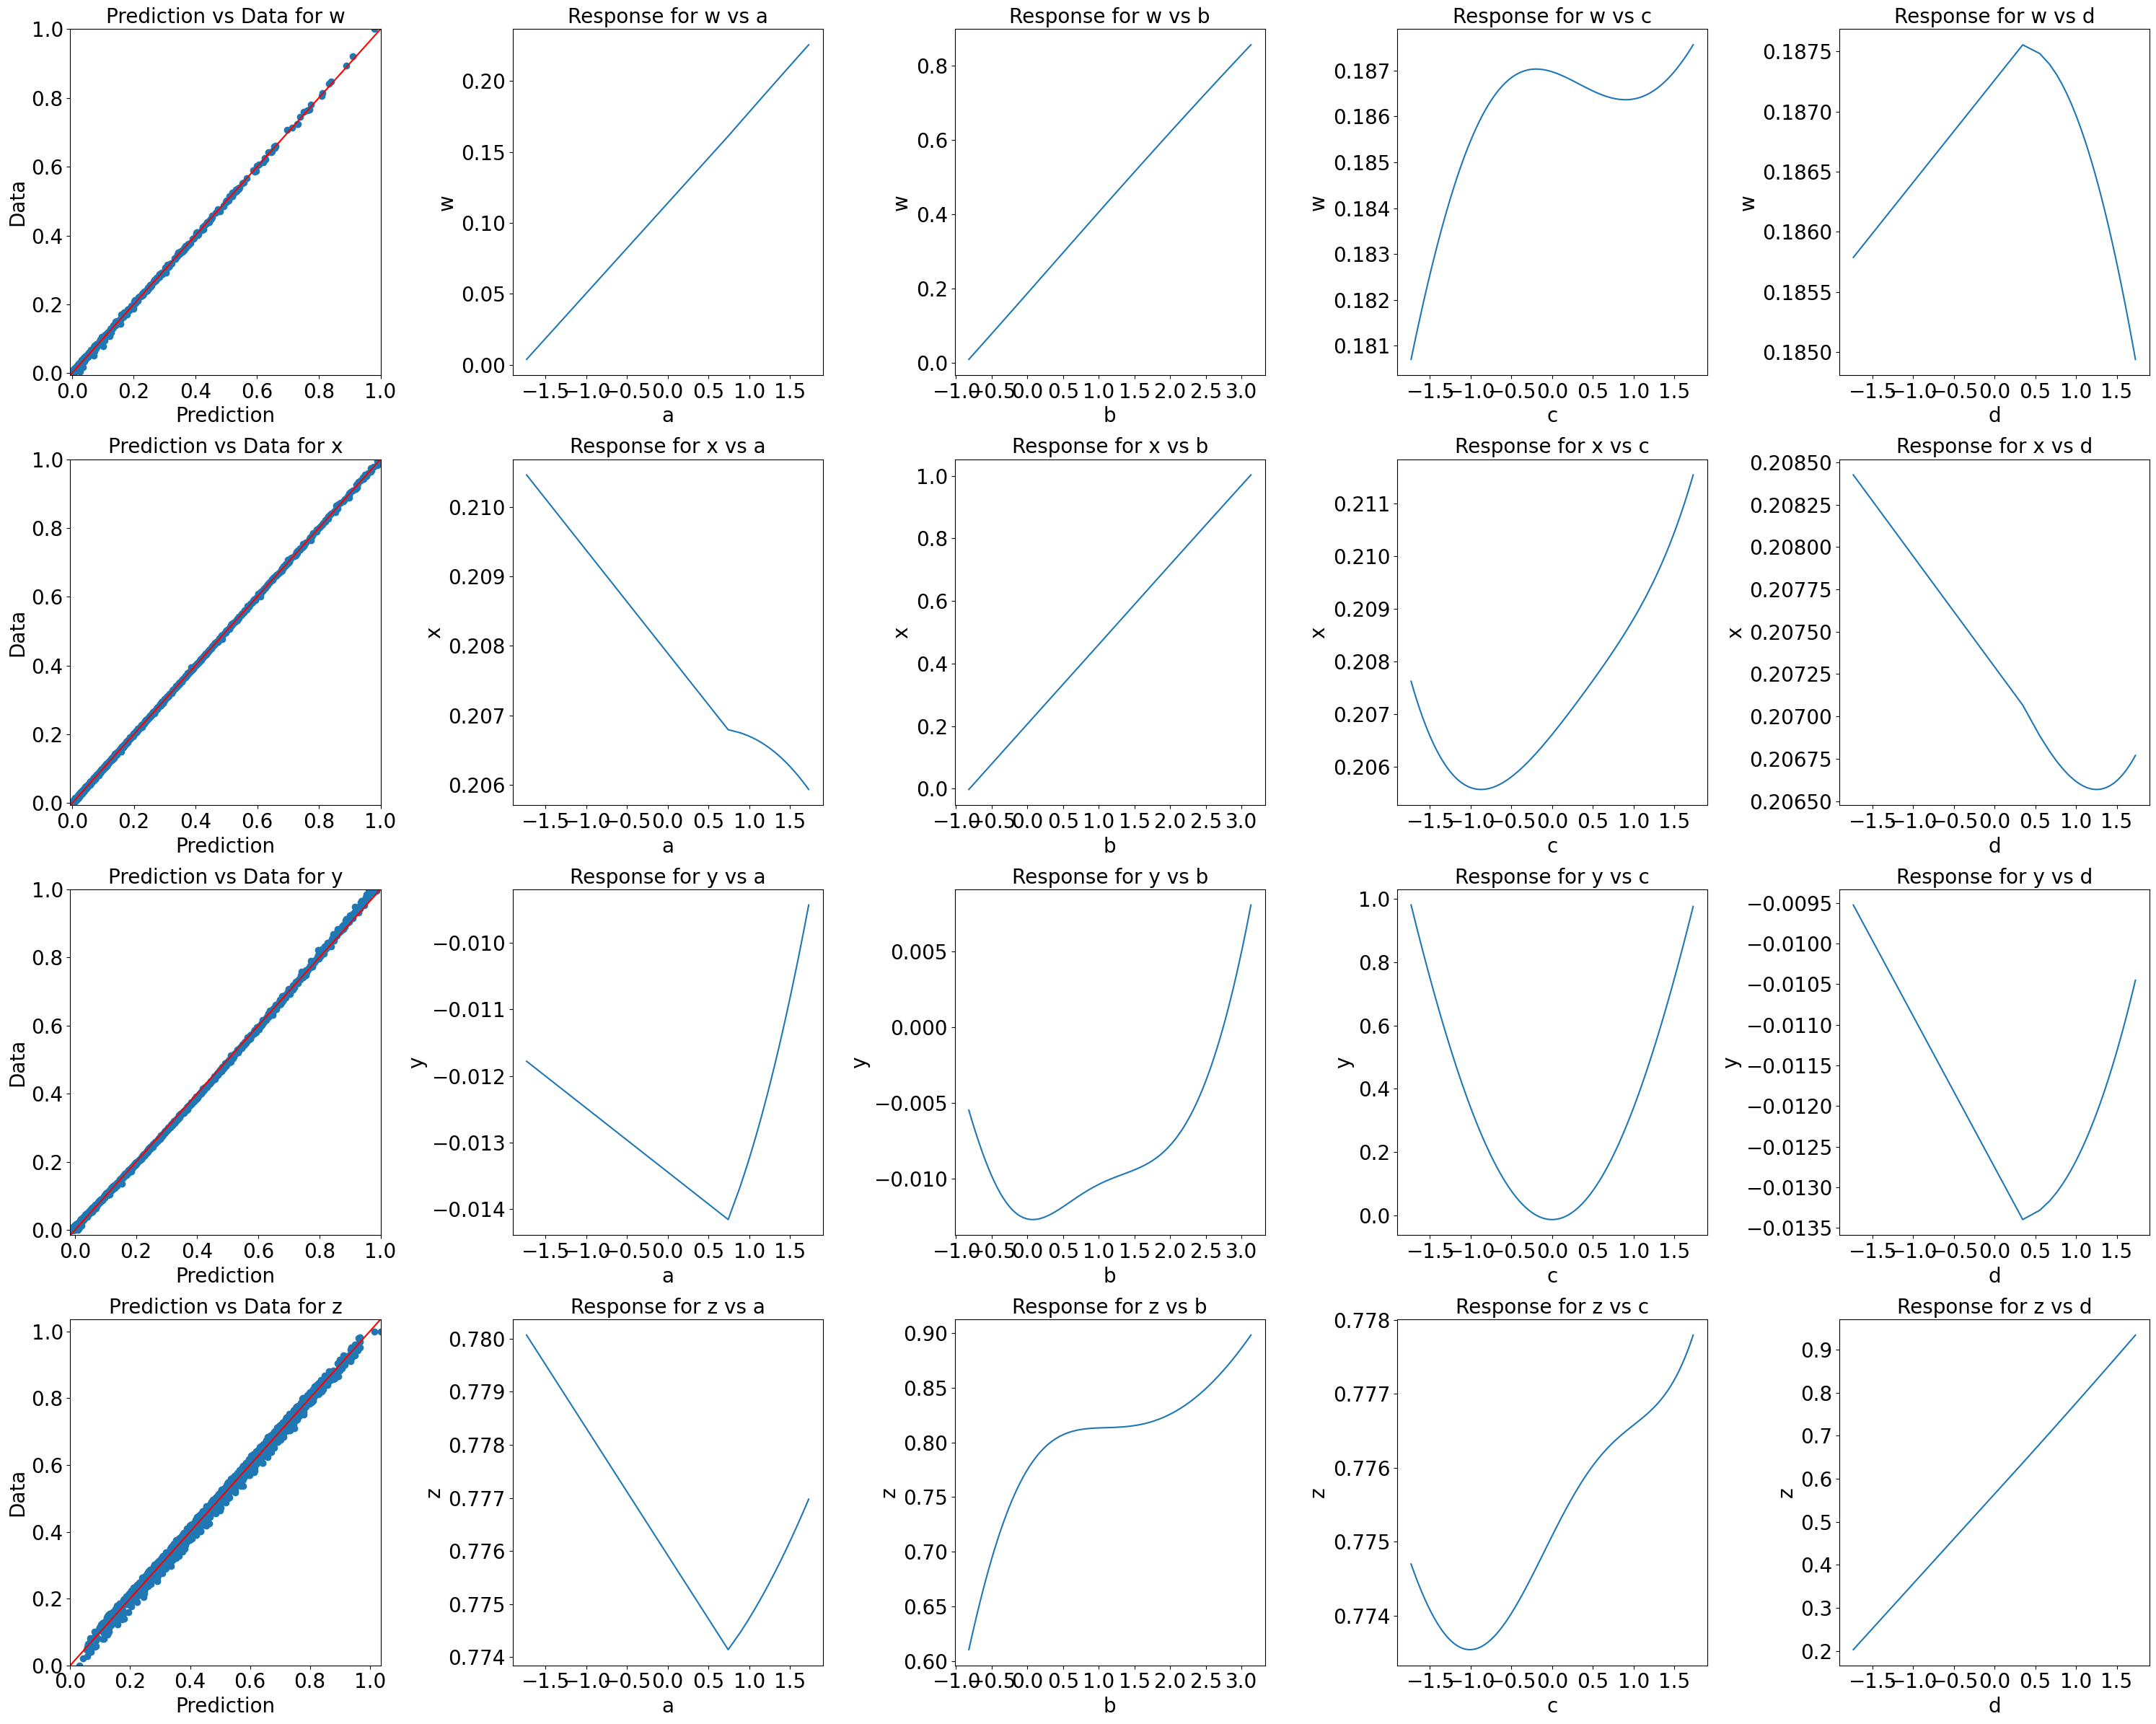

In [8]:
reg_plot.plot_scaled()

Lets autotune this to make it better

In [9]:
optuna_parameters = OptunaParameters(number_of_trials=50, min_epochs=100)
mlp_regressor.auto_tune(optuna_parameters)

[I 2024-04-09 12:15:34,871] A new study created in memory with name: no-name-6fb3159d-ac98-453a-b2f2-2f90474bfea6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 9.4 K 
---------------------------------------
9.4 K     Trainable params
0         Non-trainable params
9.4 K     Total params
0.038     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 249: 100%|██████████| 2/2 [00:00<00:00, 32.56it/s, val_loss=0.0511, train_loss=0.0508] 

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 2/2 [00:00<00:00, 26.70it/s, val_loss=0.0511, train_loss=0.0508]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 123.40it/s]


[I 2024-04-09 12:15:49,347] Trial 0 finished with value: 0.17575026184074546 and parameters: {'batch_size': 9, 'learning_rate_init': 0.00011381683731540223, 'layers': 4, 'learning_rate_factor': 0.39546848638697396, 'layer_size_0': 1, 'layer_size_1': 3, 'layer_size_2': 6, 'layer_size_3': 7}. Best is trial 0 with value: 0.17575026184074546.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 460   
---------------------------------------
460       Trainable params
0         Non-trainable params
460       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 11/11 [00:00<00:00, 11.87it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 60.43it/s, val_loss=0.000415, train_loss=0.000402] 

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 57.16it/s, val_loss=0.000415, train_loss=0.000402]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 240.93it/s]


[I 2024-04-09 12:16:22,355] Trial 1 finished with value: 3.994920532910694 and parameters: {'batch_size': 6, 'learning_rate_init': 0.00026140960411616095, 'layers': 2, 'learning_rate_factor': 0.2828843288370007, 'layer_size_0': 5, 'layer_size_1': 3}. Best is trial 0 with value: 0.17575026184074546.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 19.1 K
---------------------------------------
19.1 K    Trainable params
0         Non-trainable params
19.1 K    Total params
0.076     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 249: 100%|██████████| 2/2 [00:00<00:00, 70.49it/s, val_loss=0.000134, train_loss=0.000133] 

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 2/2 [00:00<00:00, 61.60it/s, val_loss=0.000134, train_loss=0.000133]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 101.96it/s]


[I 2024-04-09 12:16:37,230] Trial 2 finished with value: 0.019672102089774088 and parameters: {'batch_size': 9, 'learning_rate_init': 0.0023025632600377345, 'layers': 2, 'learning_rate_factor': 0.4720369644317951, 'layer_size_0': 5, 'layer_size_1': 9}. Best is trial 2 with value: 0.019672102089774088.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 42.2 K
---------------------------------------
42.2 K    Trainable params
0         Non-trainable params
42.2 K    Total params
0.169     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 6/6 [00:00<00:00,  6.73it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 100: 100%|██████████| 6/6 [00:00<00:00, 178.17it/s, val_loss=0.00018, train_loss=0.000216]

[I 2024-04-09 12:16:45,973] Trial 3 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 582   
---------------------------------------
582       Trainable params
0         Non-trainable params
582       Total params
0.002     Total estimated model params size (MB)


Epoch 100: 100%|██████████| 2/2 [00:00<00:00, 82.49it/s, val_loss=0.0471, train_loss=0.0472]

[I 2024-04-09 12:16:53,441] Trial 4 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 34.5 K
---------------------------------------
34.5 K    Trainable params
0         Non-trainable params
34.5 K    Total params
0.138     Total estimated model params size (MB)


Epoch 100: 100%|██████████| 11/11 [00:00<00:00, 226.36it/s, val_loss=0.0242, train_loss=0.0242]

[I 2024-04-09 12:17:15,180] Trial 5 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 51.2 K
---------------------------------------
51.2 K    Trainable params
0         Non-trainable params
51.2 K    Total params
0.205     Total estimated model params size (MB)


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 120.39it/s, val_loss=1.09e-5, train_loss=1.05e-5]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 116.53it/s, val_loss=1.09e-5, train_loss=1.05e-5]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 248.04it/s]


[I 2024-04-09 12:17:41,508] Trial 6 finished with value: 0.007207299949355788 and parameters: {'batch_size': 6, 'learning_rate_init': 0.0004988086533913916, 'layers': 3, 'learning_rate_factor': 0.4528336121681682, 'layer_size_0': 8, 'layer_size_1': 7, 'layer_size_2': 7}. Best is trial 6 with value: 0.007207299949355788.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 157 K 
---------------------------------------
157 K     Trainable params
0         Non-trainable params
157 K     Total params
0.629     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 249: 100%|██████████| 3/3 [00:00<00:00, 93.97it/s, val_loss=3.34e-5, train_loss=3.04e-5] 

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 3/3 [00:00<00:00, 87.36it/s, val_loss=3.34e-5, train_loss=3.04e-5]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 169.72it/s]


[I 2024-04-09 12:17:55,120] Trial 7 finished with value: 0.010731684118304455 and parameters: {'batch_size': 8, 'learning_rate_init': 0.0016563559345590887, 'layers': 6, 'learning_rate_factor': 0.5056175555233674, 'layer_size_0': 6, 'layer_size_1': 7, 'layer_size_2': 9, 'layer_size_3': 6, 'layer_size_4': 9, 'layer_size_5': 5}. Best is trial 6 with value: 0.007207299949355788.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 100 K 
---------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.402     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 100: 100%|██████████| 2/2 [00:00<00:00, 155.43it/s, val_loss=0.000129, train_loss=0.000128]

[I 2024-04-09 12:18:01,076] Trial 8 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 4.6 K 
---------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)


Epoch 100: 100%|██████████| 2/2 [00:00<00:00, 167.19it/s, val_loss=0.0002, train_loss=0.0002]   

[I 2024-04-09 12:18:06,689] Trial 9 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 292 K 
---------------------------------------
292 K     Trainable params
0         Non-trainable params
292 K     Total params
1.168     Total estimated model params size (MB)


Epoch 100: 100%|██████████| 6/6 [00:00<00:00, 204.42it/s, val_loss=0.00688, train_loss=0.00659]

[I 2024-04-09 12:18:26,048] Trial 10 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 63.2 K
---------------------------------------
63.2 K    Trainable params
0         Non-trainable params
63.2 K    Total params
0.253     Total estimated model params size (MB)


Epoch 100: 100%|██████████| 3/3 [00:00<00:00, 170.93it/s, val_loss=0.0736, train_loss=0.073]

[I 2024-04-09 12:18:33,154] Trial 11 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 309 K 
---------------------------------------
309 K     Trainable params
0         Non-trainable params
309 K     Total params
1.239     Total estimated model params size (MB)


Epoch 100: 100%|██████████| 3/3 [00:00<00:00, 173.35it/s, val_loss=0.00147, train_loss=0.00145]

[I 2024-04-09 12:18:46,195] Trial 12 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 203 K 
---------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.816     Total estimated model params size (MB)


Epoch 249: 100%|██████████| 6/6 [00:00<00:00, 100.56it/s, val_loss=8.89e-6, train_loss=5.27e-6]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 6/6 [00:00<00:00, 94.57it/s, val_loss=8.89e-6, train_loss=5.27e-6] 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 440.61it/s]


[I 2024-04-09 12:19:05,334] Trial 13 finished with value: 0.008808668716973717 and parameters: {'batch_size': 7, 'learning_rate_init': 0.0011595988486225194, 'layers': 6, 'learning_rate_factor': 0.6234740559219429, 'layer_size_0': 8, 'layer_size_1': 9, 'layer_size_2': 7, 'layer_size_3': 4, 'layer_size_4': 6, 'layer_size_5': 5}. Best is trial 6 with value: 0.007207299949355788.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 160 K 
---------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.644     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 11/11 [00:00<00:00, 11.65it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 100: 100%|██████████| 11/11 [00:00<00:00, 218.71it/s, val_loss=0.00566, train_loss=0.00532]

[I 2024-04-09 12:19:16,741] Trial 14 pruned. Trial was pruned at epoch 100.


Epoch 100: 100%|██████████| 11/11 [00:05<00:00,  2.07it/s, val_loss=0.00566, train_loss=0.00532] 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 100 K 
---------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.402     Total estimated model params size (MB)


Epoch 100: 100%|██████████| 6/6 [00:00<00:00, 213.19it/s, val_loss=0.000132, train_loss=0.000132]

[I 2024-04-09 12:19:30,319] Trial 15 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 307 K 
---------------------------------------
307 K     Trainable params
0         Non-trainable params
307 K     Total params
1.232     Total estimated model params size (MB)


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 131.46it/s, val_loss=4.33e-6, train_loss=2.24e-6]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 112.91it/s, val_loss=4.33e-6, train_loss=2.24e-6]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 306.81it/s]


[I 2024-04-09 12:19:56,916] Trial 16 finished with value: 0.0034302934212566217 and parameters: {'batch_size': 6, 'learning_rate_init': 0.0006977324641537885, 'layers': 6, 'learning_rate_factor': 0.5612750741090952, 'layer_size_0': 9, 'layer_size_1': 9, 'layer_size_2': 6, 'layer_size_3': 3, 'layer_size_4': 6, 'layer_size_5': 7}. Best is trial 16 with value: 0.0034302934212566217.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 19.1 K
---------------------------------------
19.1 K    Trainable params
0         Non-trainable params
19.1 K    Total params
0.077     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 11/11 [00:01<00:00,  9.63it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 100: 100%|██████████| 11/11 [00:00<00:00, 229.53it/s, val_loss=0.00123, train_loss=0.00134]

[I 2024-04-09 12:20:08,881] Trial 17 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 22.7 K
---------------------------------------
22.7 K    Trainable params
0         Non-trainable params
22.7 K    Total params
0.091     Total estimated model params size (MB)


Epoch 100: 100%|██████████| 11/11 [00:00<00:00, 194.03it/s, val_loss=0.0269, train_loss=0.0268]

[I 2024-04-09 12:20:26,486] Trial 18 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 4.6 K 
---------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)


Epoch 100: 100%|██████████| 11/11 [00:00<00:00, 238.14it/s, val_loss=0.000223, train_loss=0.000215]

[I 2024-04-09 12:20:38,284] Trial 19 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 35.6 K
---------------------------------------
35.6 K    Trainable params
0         Non-trainable params
35.6 K    Total params
0.142     Total estimated model params size (MB)


Epoch 100: 100%|██████████| 6/6 [00:00<00:00, 195.74it/s, val_loss=0.000155, train_loss=0.000149]

[I 2024-04-09 12:20:47,115] Trial 20 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 206 K 
---------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.824     Total estimated model params size (MB)


Epoch 249: 100%|██████████| 6/6 [00:00<00:00, 34.37it/s, val_loss=8.25e-6, train_loss=5.9e-6]  

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 6/6 [00:00<00:00, 32.86it/s, val_loss=8.25e-6, train_loss=5.9e-6]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 128.90it/s]


[I 2024-04-09 12:21:23,429] Trial 21 finished with value: 0.005494260332612423 and parameters: {'batch_size': 7, 'learning_rate_init': 0.0009148058538595117, 'layers': 6, 'learning_rate_factor': 0.6997531637193852, 'layer_size_0': 8, 'layer_size_1': 9, 'layer_size_2': 7, 'layer_size_3': 5, 'layer_size_4': 5, 'layer_size_5': 6}. Best is trial 16 with value: 0.0034302934212566217.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 237 K 
---------------------------------------
237 K     Trainable params
0         Non-trainable params
237 K     Total params
0.949     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 11/11 [00:01<00:00,  8.99it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 134.97it/s, val_loss=6.7e-6, train_loss=4.92e-6] 

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 116.48it/s, val_loss=6.7e-6, train_loss=4.92e-6]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 136.38it/s]


[I 2024-04-09 12:21:53,937] Trial 22 finished with value: 0.0070617923825547135 and parameters: {'batch_size': 6, 'learning_rate_init': 0.0007689362549359749, 'layers': 7, 'learning_rate_factor': 0.6986452333774061, 'layer_size_0': 8, 'layer_size_1': 9, 'layer_size_2': 6, 'layer_size_3': 5, 'layer_size_4': 3, 'layer_size_5': 7, 'layer_size_6': 9}. Best is trial 16 with value: 0.0034302934212566217.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 171 K 
---------------------------------------
171 K     Trainable params
0         Non-trainable params
171 K     Total params
0.684     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 6/6 [00:01<00:00,  5.04it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 249: 100%|██████████| 6/6 [00:00<00:00, 97.26it/s, val_loss=1.5e-5, train_loss=1.15e-5]  

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 6/6 [00:00<00:00, 92.70it/s, val_loss=1.5e-5, train_loss=1.15e-5]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 210.35it/s]


[I 2024-04-09 12:22:14,732] Trial 23 finished with value: 0.004381802172262746 and parameters: {'batch_size': 7, 'learning_rate_init': 0.0007861586800919237, 'layers': 7, 'learning_rate_factor': 0.7167814144178924, 'layer_size_0': 7, 'layer_size_1': 9, 'layer_size_2': 6, 'layer_size_3': 5, 'layer_size_4': 3, 'layer_size_5': 7, 'layer_size_6': 9}. Best is trial 16 with value: 0.0034302934212566217.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 41.5 K
---------------------------------------
41.5 K    Trainable params
0         Non-trainable params
41.5 K    Total params
0.166     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 100: 100%|██████████| 6/6 [00:00<00:00, 207.73it/s, val_loss=6.43e-5, train_loss=5.38e-5] 

[I 2024-04-09 12:22:24,399] Trial 24 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 407 K 
---------------------------------------
407 K     Trainable params
0         Non-trainable params
407 K     Total params
1.630     Total estimated model params size (MB)


Epoch 100: 100%|██████████| 3/3 [00:00<00:00, 135.34it/s, val_loss=0.0142, train_loss=0.0123]

[I 2024-04-09 12:22:38,122] Trial 25 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 64.7 K
---------------------------------------
64.7 K    Trainable params
0         Non-trainable params
64.7 K    Total params
0.259     Total estimated model params size (MB)


Epoch 100: 100%|██████████| 6/6 [00:00<00:00, 176.15it/s, val_loss=0.136, train_loss=0.135]

[I 2024-04-09 12:22:47,454] Trial 26 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 11.3 K
---------------------------------------
11.3 K    Trainable params
0         Non-trainable params
11.3 K    Total params
0.045     Total estimated model params size (MB)


Epoch 100: 100%|██████████| 6/6 [00:00<00:00, 160.56it/s, val_loss=0.000172, train_loss=0.000154]

[I 2024-04-09 12:22:57,111] Trial 27 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 13.8 K
---------------------------------------
13.8 K    Trainable params
0         Non-trainable params
13.8 K    Total params
0.055     Total estimated model params size (MB)


Epoch 100: 100%|██████████| 3/3 [00:00<00:00, 133.40it/s, val_loss=0.00692, train_loss=0.00773]

[I 2024-04-09 12:23:14,812] Trial 28 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 282 K 
---------------------------------------
282 K     Trainable params
0         Non-trainable params
282 K     Total params
1.131     Total estimated model params size (MB)


Epoch 100: 100%|██████████| 6/6 [00:00<00:00, 186.39it/s, val_loss=0.134, train_loss=0.134]

[I 2024-04-09 12:23:23,873] Trial 29 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 31.6 K
---------------------------------------
31.6 K    Trainable params
0         Non-trainable params
31.6 K    Total params
0.126     Total estimated model params size (MB)


Epoch 100: 100%|██████████| 6/6 [00:00<00:00, 162.31it/s, val_loss=0.000182, train_loss=0.000176]

[I 2024-04-09 12:23:32,853] Trial 30 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 237 K 
---------------------------------------
237 K     Trainable params
0         Non-trainable params
237 K     Total params
0.949     Total estimated model params size (MB)


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 135.01it/s, val_loss=5.76e-6, train_loss=3.73e-6]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 131.44it/s, val_loss=5.76e-6, train_loss=3.73e-6]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 169.14it/s]


[I 2024-04-09 12:24:11,122] Trial 31 finished with value: 0.009448958023199935 and parameters: {'batch_size': 6, 'learning_rate_init': 0.0007299836388289291, 'layers': 7, 'learning_rate_factor': 0.68044475755497, 'layer_size_0': 8, 'layer_size_1': 9, 'layer_size_2': 6, 'layer_size_3': 5, 'layer_size_4': 3, 'layer_size_5': 7, 'layer_size_6': 9}. Best is trial 16 with value: 0.0034302934212566217.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 204 K 
---------------------------------------
204 K     Trainable params
0         Non-trainable params
204 K     Total params
0.818     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 11/11 [00:01<00:00,  8.39it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 133.19it/s, val_loss=6.07e-6, train_loss=3.53e-6]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 115.66it/s, val_loss=6.07e-6, train_loss=3.53e-6]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 156.44it/s]


[I 2024-04-09 12:24:40,077] Trial 32 finished with value: 0.006323350889681047 and parameters: {'batch_size': 6, 'learning_rate_init': 0.0009151703813798939, 'layers': 7, 'learning_rate_factor': 0.7291725075277936, 'layer_size_0': 8, 'layer_size_1': 9, 'layer_size_2': 6, 'layer_size_3': 5, 'layer_size_4': 4, 'layer_size_5': 7, 'layer_size_6': 8}. Best is trial 16 with value: 0.0034302934212566217.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 81.1 K
---------------------------------------
81.1 K    Trainable params
0         Non-trainable params
81.1 K    Total params
0.325     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 11/11 [00:00<00:00, 11.17it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 100: 100%|██████████| 11/11 [00:00<00:00, 205.05it/s, val_loss=0.00727, train_loss=0.0073]

[I 2024-04-09 12:24:52,215] Trial 33 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 99.2 K
---------------------------------------
99.2 K    Trainable params
0         Non-trainable params
99.2 K    Total params
0.397     Total estimated model params size (MB)


Epoch 172: 100%|██████████| 11/11 [00:00<00:00, 129.48it/s, val_loss=9.91e-6, train_loss=8.66e-6]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 234.01it/s]


[I 2024-04-09 12:25:11,548] Trial 34 finished with value: 0.011574746895379339 and parameters: {'batch_size': 6, 'learning_rate_init': 0.0017181988666991129, 'layers': 6, 'learning_rate_factor': 0.8265624146490136, 'layer_size_0': 8, 'layer_size_1': 8, 'layer_size_2': 6, 'layer_size_3': 6, 'layer_size_4': 5, 'layer_size_5': 8}. Best is trial 16 with value: 0.0034302934212566217.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 138 K 
---------------------------------------
138 K     Trainable params
0         Non-trainable params
138 K     Total params
0.554     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 100: 100%|██████████| 6/6 [00:00<00:00, 169.83it/s, val_loss=6.11e-5, train_loss=5.82e-5] 

[I 2024-04-09 12:25:25,520] Trial 35 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 58.3 K
---------------------------------------
58.3 K    Trainable params
0         Non-trainable params
58.3 K    Total params
0.233     Total estimated model params size (MB)


Epoch 100: 100%|██████████| 11/11 [00:00<00:00, 194.14it/s, val_loss=0.0247, train_loss=0.0247]

[I 2024-04-09 12:25:37,696] Trial 36 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 4.0 K 
---------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)


Epoch 100: 100%|██████████| 11/11 [00:00<00:00, 174.94it/s, val_loss=0.00029, train_loss=0.000282]

[I 2024-04-09 12:25:50,188] Trial 37 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 299 K 
---------------------------------------
299 K     Trainable params
0         Non-trainable params
299 K     Total params
1.197     Total estimated model params size (MB)


Epoch 100: 100%|██████████| 6/6 [00:00<00:00, 174.00it/s, val_loss=0.0046, train_loss=0.00454]

[I 2024-04-09 12:26:01,428] Trial 38 pruned. Trial was pruned at epoch 100.


Epoch 100: 100%|██████████| 6/6 [00:15<00:00,  0.39it/s, val_loss=0.0046, train_loss=0.00454] 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 68.9 K
---------------------------------------
68.9 K    Trainable params
0         Non-trainable params
68.9 K    Total params
0.276     Total estimated model params size (MB)


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 150.84it/s, val_loss=1.09e-5, train_loss=8.88e-6]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 146.90it/s, val_loss=1.09e-5, train_loss=8.88e-6]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 159.40it/s]


[I 2024-04-09 12:26:45,032] Trial 39 finished with value: 0.006166675777951245 and parameters: {'batch_size': 6, 'learning_rate_init': 0.0008408700452856983, 'layers': 8, 'learning_rate_factor': 0.7309851041624796, 'layer_size_0': 6, 'layer_size_1': 8, 'layer_size_2': 7, 'layer_size_3': 3, 'layer_size_4': 7, 'layer_size_5': 5, 'layer_size_6': 7, 'layer_size_7': 6}. Best is trial 16 with value: 0.0034302934212566217.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 44.0 K
---------------------------------------
44.0 K    Trainable params
0         Non-trainable params
44.0 K    Total params
0.176     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 100: 100%|██████████| 3/3 [00:00<00:00, 155.64it/s, val_loss=0.0313, train_loss=0.0313]

[I 2024-04-09 12:26:54,081] Trial 40 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 96.6 K
---------------------------------------
96.6 K    Trainable params
0         Non-trainable params
96.6 K    Total params
0.386     Total estimated model params size (MB)


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 138.69it/s, val_loss=8.22e-6, train_loss=6.52e-6]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 135.38it/s, val_loss=8.22e-6, train_loss=6.52e-6]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 351.39it/s]


[I 2024-04-09 12:27:21,870] Trial 41 finished with value: 0.007929391908552715 and parameters: {'batch_size': 6, 'learning_rate_init': 0.0008730941434945082, 'layers': 8, 'learning_rate_factor': 0.7396148413970897, 'layer_size_0': 6, 'layer_size_1': 9, 'layer_size_2': 6, 'layer_size_3': 3, 'layer_size_4': 6, 'layer_size_5': 7, 'layer_size_6': 7, 'layer_size_7': 5}. Best is trial 16 with value: 0.0034302934212566217.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 191 K 
---------------------------------------
191 K     Trainable params
0         Non-trainable params
191 K     Total params
0.766     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 11/11 [00:00<00:00, 12.35it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 125.78it/s, val_loss=3.63e-6, train_loss=2.9e-6] 

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 122.05it/s, val_loss=3.63e-6, train_loss=2.9e-6]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 180.53it/s]


[I 2024-04-09 12:27:48,330] Trial 42 finished with value: 0.005648477576703692 and parameters: {'batch_size': 6, 'learning_rate_init': 0.0010426745686100266, 'layers': 7, 'learning_rate_factor': 0.7222502865833907, 'layer_size_0': 7, 'layer_size_1': 9, 'layer_size_2': 7, 'layer_size_3': 7, 'layer_size_4': 8, 'layer_size_5': 4, 'layer_size_6': 8}. Best is trial 16 with value: 0.0034302934212566217.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 125 K 
---------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.500     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 11/11 [00:00<00:00, 11.86it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 137.87it/s, val_loss=5.26e-6, train_loss=4.31e-6]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 122.67it/s, val_loss=5.26e-6, train_loss=4.31e-6]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 241.71it/s]


[I 2024-04-09 12:28:15,560] Trial 43 finished with value: 0.007011995046481394 and parameters: {'batch_size': 6, 'learning_rate_init': 0.00136279812998276, 'layers': 8, 'learning_rate_factor': 0.6655483620837445, 'layer_size_0': 7, 'layer_size_1': 7, 'layer_size_2': 7, 'layer_size_3': 7, 'layer_size_4': 8, 'layer_size_5': 4, 'layer_size_6': 8, 'layer_size_7': 7}. Best is trial 16 with value: 0.0034302934212566217.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 155 K 
---------------------------------------
155 K     Trainable params
0         Non-trainable params
155 K     Total params
0.622     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 11/11 [00:01<00:00, 10.53it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 100: 100%|██████████| 11/11 [00:00<00:00, 212.48it/s, val_loss=8.93e-5, train_loss=7.02e-5] 

[I 2024-04-09 12:28:27,635] Trial 44 pruned. Trial was pruned at epoch 100.


Epoch 100: 100%|██████████| 11/11 [00:05<00:00,  2.06it/s, val_loss=8.93e-5, train_loss=7.02e-5] 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 239 K 
---------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.958     Total estimated model params size (MB)


Epoch 100: 100%|██████████| 6/6 [00:00<00:00, 177.45it/s, val_loss=4.94e-5, train_loss=5.21e-5] 

[I 2024-04-09 12:28:41,313] Trial 45 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 177 K 
---------------------------------------
177 K     Trainable params
0         Non-trainable params
177 K     Total params
0.710     Total estimated model params size (MB)


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 116.43it/s, val_loss=1.58e-5, train_loss=2.22e-5]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 112.49it/s, val_loss=1.58e-5, train_loss=2.22e-5]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 427.56it/s]


[I 2024-04-09 12:29:07,470] Trial 46 finished with value: 0.00686351130786493 and parameters: {'batch_size': 6, 'learning_rate_init': 0.0018117292067702543, 'layers': 7, 'learning_rate_factor': 0.6488608651780561, 'layer_size_0': 5, 'layer_size_1': 8, 'layer_size_2': 8, 'layer_size_3': 8, 'layer_size_4': 7, 'layer_size_5': 3, 'layer_size_6': 8}. Best is trial 16 with value: 0.0034302934212566217.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 32.2 K
---------------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 6/6 [00:01<00:00,  5.05it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 100: 100%|██████████| 6/6 [00:00<00:00, 109.77it/s, val_loss=0.00635, train_loss=0.00613]

[I 2024-04-09 12:29:16,830] Trial 47 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 349 K 
---------------------------------------
349 K     Trainable params
0         Non-trainable params
349 K     Total params
1.398     Total estimated model params size (MB)


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 96.70it/s, val_loss=5.78e-6, train_loss=4.9e-6]  

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 92.57it/s, val_loss=5.78e-6, train_loss=4.9e-6]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 282.95it/s]


[I 2024-04-09 12:29:43,949] Trial 48 finished with value: 0.007503039852166113 and parameters: {'batch_size': 6, 'learning_rate_init': 0.0008054263282398604, 'layers': 6, 'learning_rate_factor': 0.7696231497913605, 'layer_size_0': 7, 'layer_size_1': 9, 'layer_size_2': 9, 'layer_size_3': 2, 'layer_size_4': 8, 'layer_size_5': 6}. Best is trial 16 with value: 0.0034302934212566217.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 2.8 K 
---------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 100: 100%|██████████| 3/3 [00:00<00:00, 178.17it/s, val_loss=0.00399, train_loss=0.00402]

[I 2024-04-09 12:29:51,049] Trial 49 pruned. Trial was pruned at epoch 100.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | Sequential | 307 K 
---------------------------------------
307 K     Trainable params
0         Non-trainable params
307 K     Total params
1.232     Total estimated model params size (MB)


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 109.58it/s, val_loss=8.33e-6, train_loss=3.94e-6]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 11/11 [00:00<00:00, 106.87it/s, val_loss=8.33e-6, train_loss=3.94e-6]


In [10]:
print(f"Error: {mlp_regressor.error_metrics()['nrmse']}")
print(mlp_regressor.parameters.get_mlp_parameters())

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 159.70it/s]
Error: 0.008223969049087721
MLPParameters(input_dim=4, output_dim=4, hidden_layer_sizes=[512, 512, 64, 8, 64, 128], activation=<class 'torch.nn.modules.activation.SiLU'>, learning_rate='adaptive', learning_rate_init=0.0006977324641537885, learning_rate_patience=10, learning_rate_factor=0.5612750741090952)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 135.67it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 127.92it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 123.93it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 131.96it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 127.50it/s]


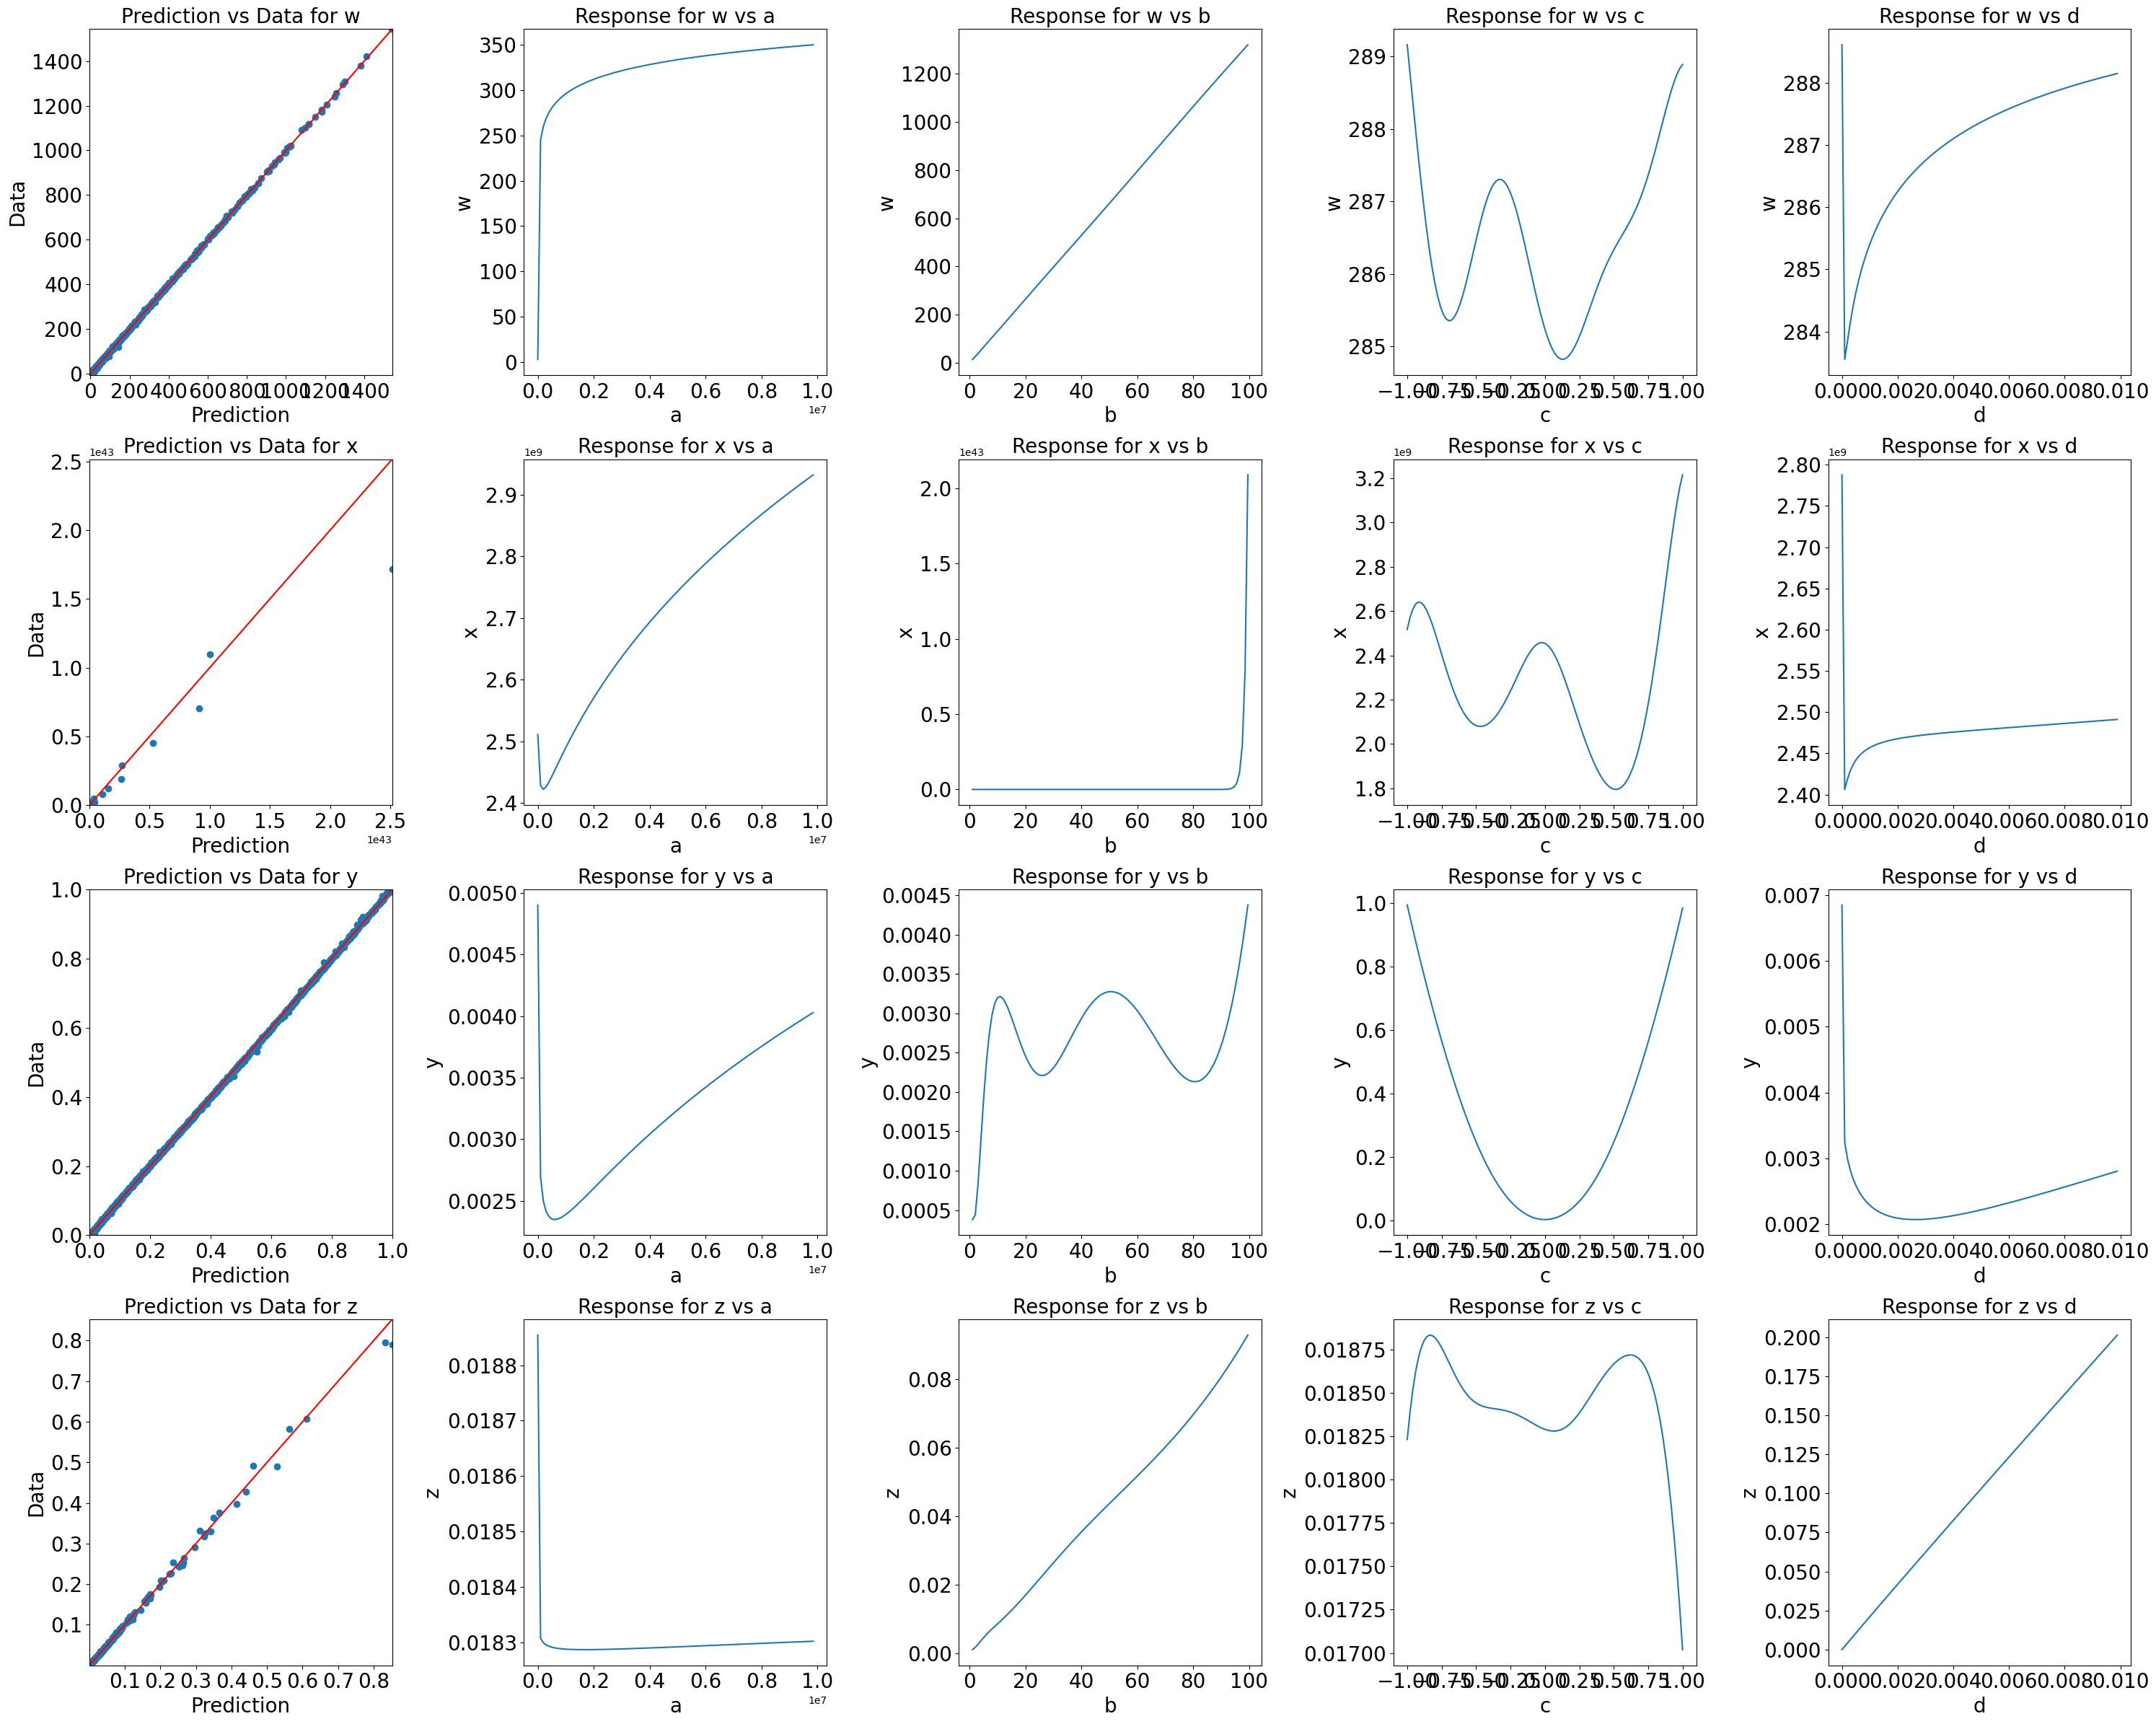

In [11]:
params = RegressorPlotParameters(mlp_regressor, app.factors.mean(), app.factors.min(), app.factors.max())
reg_plot = RegressorPlot(params)
reg_plot.plot()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 138.58it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 126.01it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 127.00it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 122.35it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 121.83it/s]


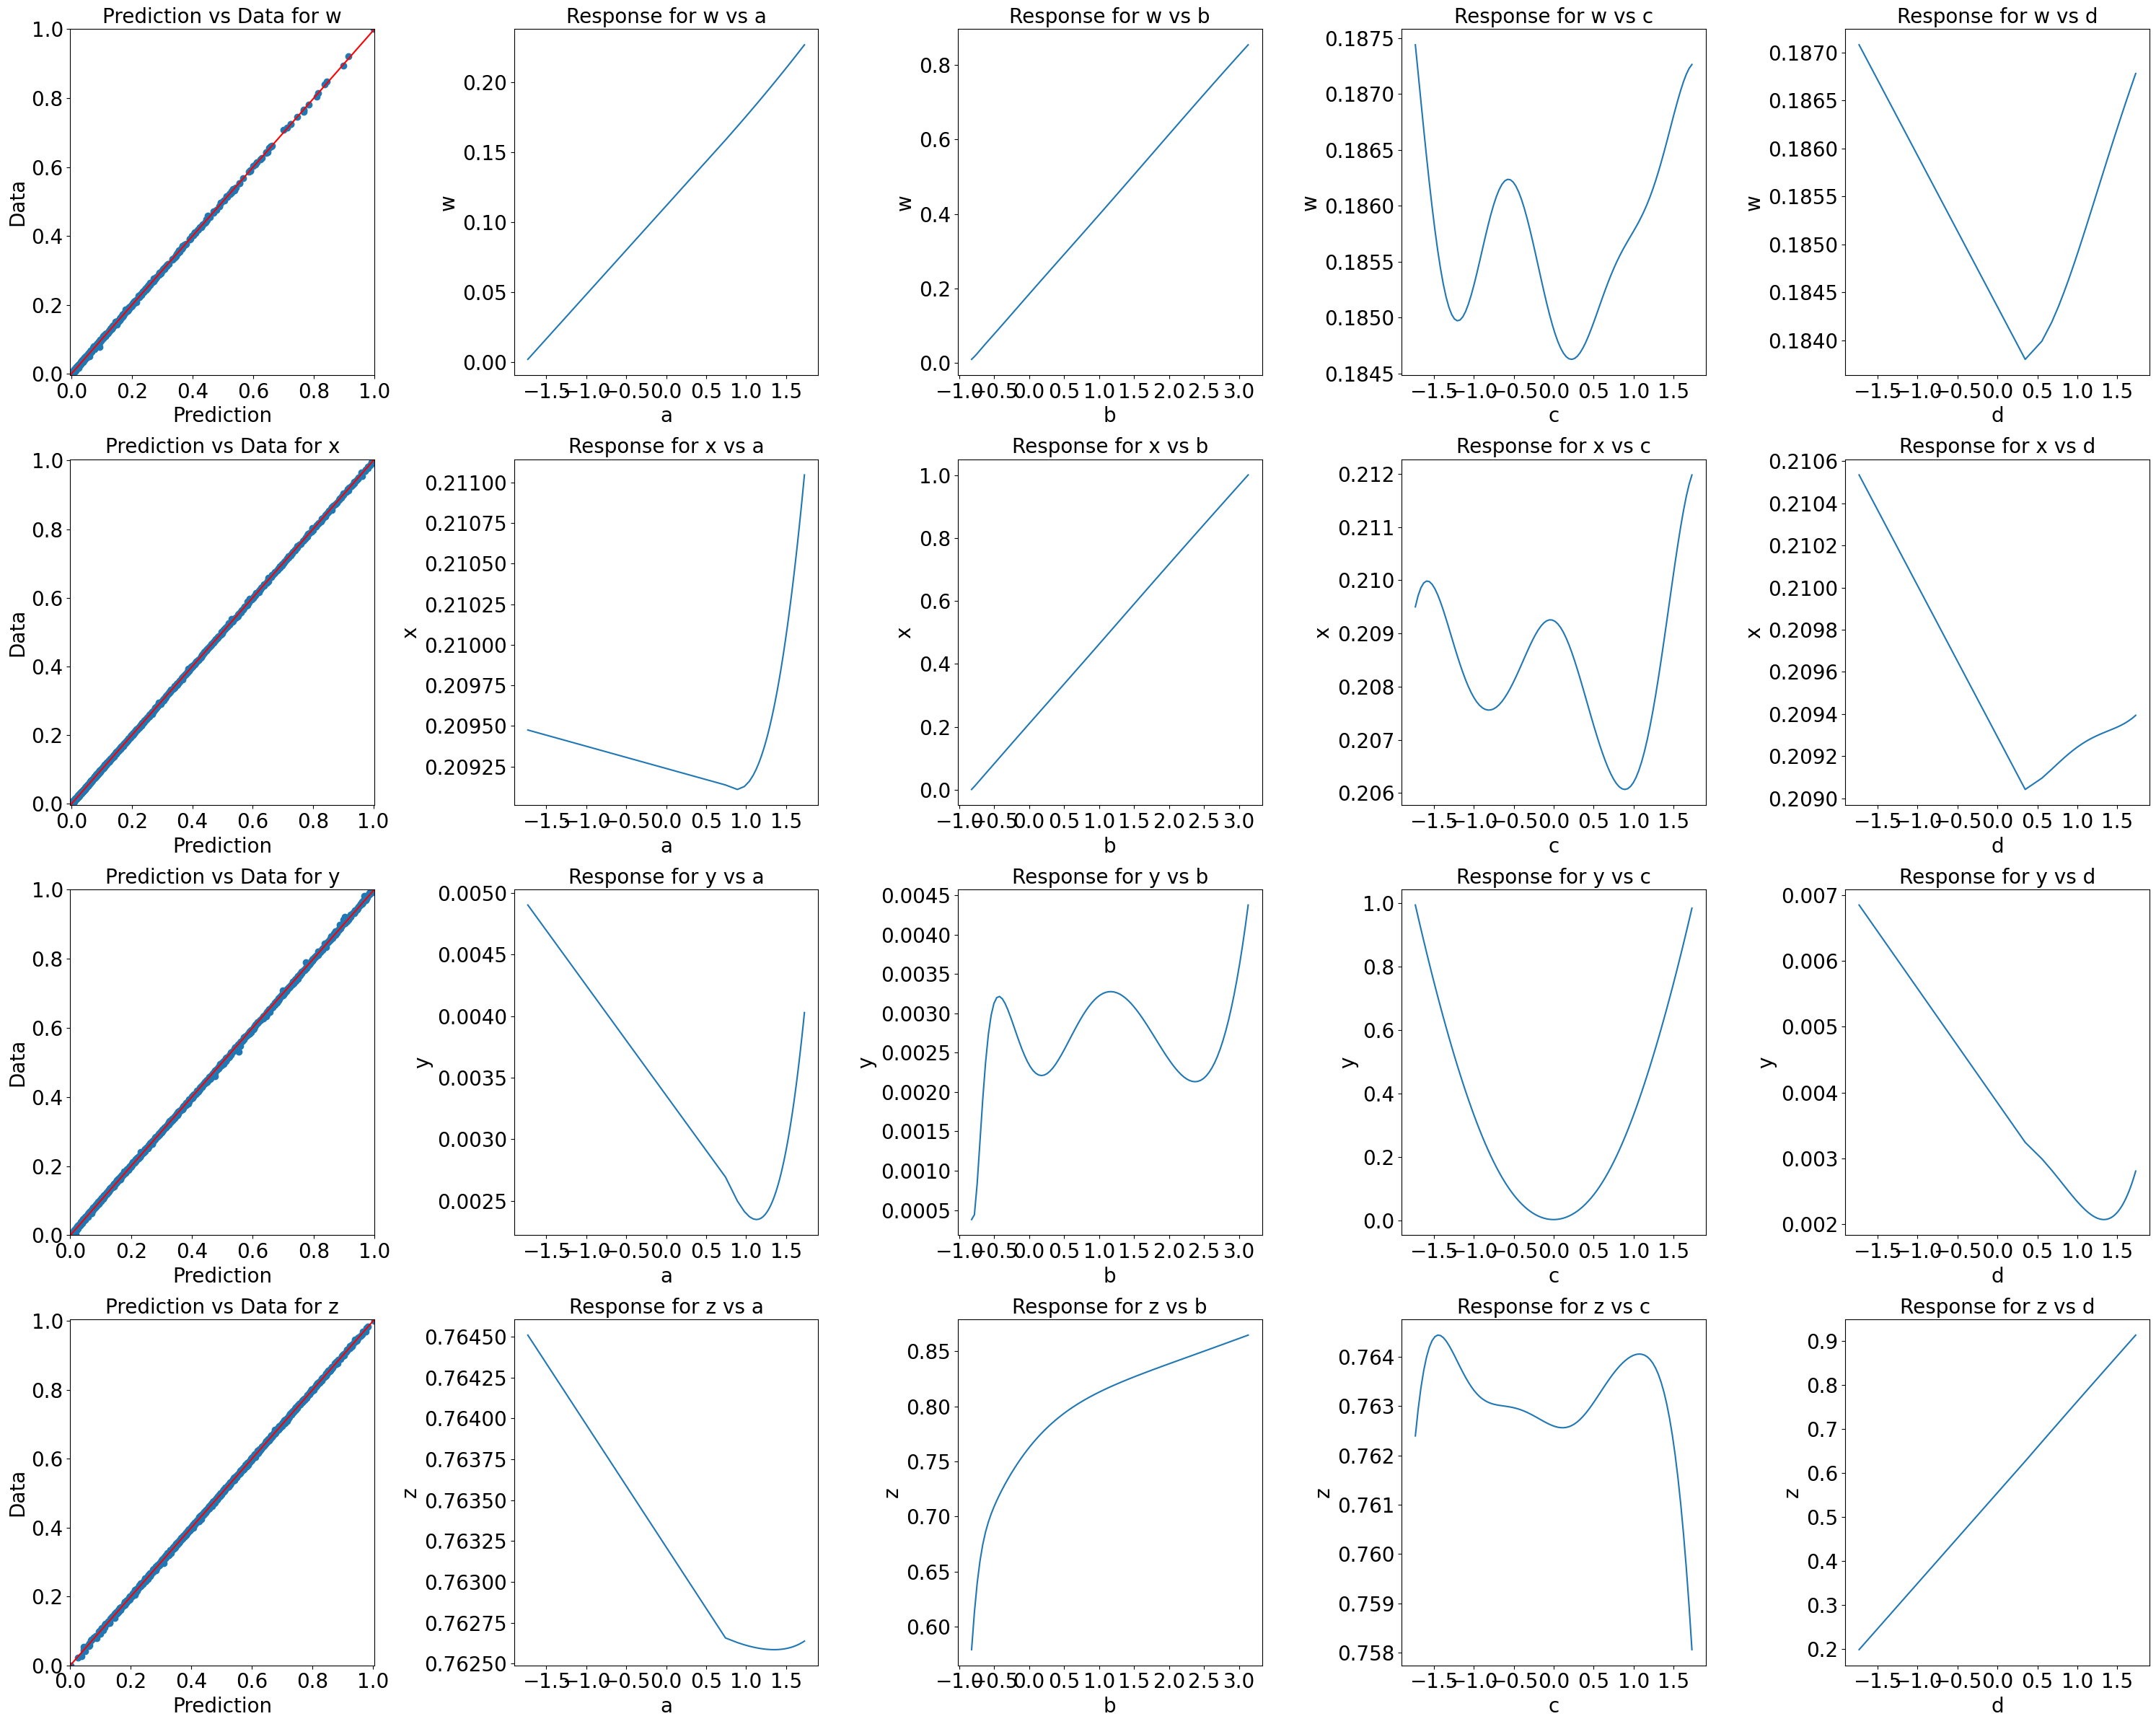

In [12]:
reg_plot.plot_scaled()

In [13]:
#app.factors.to_csv("factors.csv", index=False)
#app.responses.to_csv("responses.csv", index=False)